# Quantization aware (QKeras) DeepSet Permutation Invariant NN for Jet tagging using jet constituents from HLS data implemented by Patrick ( from paper https://arxiv.org/abs/1703.06114 )

##   Original code from: https://github.com/bb511/know_dist

## Author: Andre Sznajder

 

In [1]:
#!fusermount -u drive
#! pip install einops
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'

In [2]:
import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
print(tf.config.list_physical_devices())
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    

# To disable GPU use
tf.config.set_visible_devices([], 'GPU')


TensorFlow 2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of available GPUs : 1


## Load train and test JetID datasets as numpy arrays

In [3]:
import numpy as np
import h5py
import os

#Data PATH
DATA_PATH = '/Users/sznajder/WorkM1/workdir/data/'

nconstit = 32

X_train_val = np.load("../../data/X_train_val_nconst_{}.npy".format(nconstit))
X_test = np.load("../../data/X_test_nconst_{}.npy".format(nconstit))
Y_train_val = np.load("../../data/Y_train_val_nconst_{}.npy".format(nconstit))
Y_test = np.load("../../data/Y_test_nconst_{}.npy".format(nconstit))

print("Loaded X_train_val ----> shape:", X_train_val.shape)
print("Loaded X_test      ----> shape:", X_test.shape)
print("Loaded Y_train_val ----> shape:", X_train_val.shape)
print("Loaded Y_test      ----> shape:", X_test.shape)

nfeat = X_train_val.shape[-1]


Loaded X_train_val ----> shape: (589600, 32, 3)
Loaded X_test      ----> shape: (290400, 32, 3)
Loaded Y_train_val ----> shape: (589600, 32, 3)
Loaded Y_test      ----> shape: (290400, 32, 3)


## Define DeepSet Permutation Invariant Model

In [4]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, Input, Activation, Dense, Conv1D, Add, RepeatVector
from tensorflow.keras.layers import Flatten, Reshape, GlobalAveragePooling1D, Concatenate, UpSampling1D, AveragePooling1D, MaxPooling1D  
from tensorflow.keras import utils
from qkeras import *

import tensorflow.keras.layers as KL



#########################################################################################################
'''
# Silence the info from tensorflow in which it brags that it can run on cpu nicely.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
keras.utils.set_random_seed(123)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

from util.terminal_colors import tcols
from . import util as dsutil

tf.keras.backend.set_floatx("float64")

util.util.device_info()
outdir = util.util.make_output_directory("trained_deepsets", args["outdir"])
util.util.save_hyperparameters_file(args, outdir)

data = Data.shuffled(**args["data_hyperparams"])
'''
#########################################################################################################

# Quantized bits
nbits=8
integ=0

#qbits = quantized_bits(nbits,integ,alpha=1.0)
#qact = 'quantized_relu('+str(nbits)+',0)'

# Set QKeras quantizer and activation 
if nbits == 1:
    qbits = 'binary(alpha=1)'
elif nbits == 2:
    qbits = 'ternary(alpha=1)'
else:
    qbits = 'quantized_bits({},0,alpha=1)'.format(nbits)

qact = 'quantized_relu({},0)'.format(nbits)

# Print
print("Training with max # of contituents = ", nconstit)
print("Number of node features = ", nfeat)
print("Quantization with nbits=",nbits)
print("Quantization of integer part=",integ)

#############################################################################


nnodes_phi = 32
nnodes_rho = 32
activ      = "relu"
#activ      = "elu"

# Number of target classes
nclasses = len(Y_train_val[0]) 

# Instantiate Tensorflow input tensors in Batch mode 
inp = Input(shape=(nconstit,nfeat), name="inp")   # Conv1D input format


# Input point features BatchNormalization 
#h = BatchNormalization(name='BatchNorm')(inp)
h = QBatchNormalization(name='batchnorm', beta_quantizer=qbits, gamma_quantizer=qbits)(inp)

# Phi MLP ( permutation equivariant layers )
h = QDense(nnodes_phi, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_phi1' )(h)
h = QActivation(qact,name='qrelu_phi1')(h)
h = QDense(nnodes_phi, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_phi2' )(h)
h = QActivation(qact,name='qrelu_phi2')(h)
h = QDense(nnodes_phi, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_phi3' )(h)
phi_out = QActivation(qact,name='qrelu_phi3')(h)
 
# Linear activation to change HLS bitwidth to fix overflow in AveragePooling
#h = QActivation(activation='quantized_bits(14,5)', name = 'linear_activation')(h)

# Agregate features (taking mean) over set elements  
mean = GlobalAveragePooling1D(name='avgpool')(phi_out)      # return mean of features over elements
#mean = tf.reduce_mean(phi_out, axis=1)                     # return mean of features over elements


# Rho MLP
h = QDense(nnodes_rho, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_rho1' )(mean)
h = QActivation(qact,name='qrelu_rho1')(h)
h = QDense(nnodes_rho, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_rho2' )(h)
h = QActivation(qact,name='qrelu_rho2')(h)
h = QDense(nclasses, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_rho3' )(h)
out = Activation('softmax',name='softmax')(h)

# Build the model
model = Model(inputs=inp, outputs=out)

# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0001,decay=1e-6)
optim = Adam(learning_rate=0.0003)
#optim = Adam()

# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()




Training with max # of contituents =  32
Number of node features =  3
Quantization with nbits= 8
Quantization of integer part= 0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 32, 3)]           0         
                                                                 
 batchnorm (QBatchNormalizat  (None, 32, 3)            12        
 ion)                                                            
                                                                 
 qdense_phi1 (QDense)        (None, 32, 32)            128       
                                                                 
 qrelu_phi1 (QActivation)    (None, 32, 32)            0         
                                                                 
 qdense_phi2 (QDense)        (None, 32, 32)            1056      
                                                                

## Run training

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Figure o merit to monitor during training
#merit = 'val_categorical_accuracy'
merit = 'val_loss'


# early stopping callback
es = EarlyStopping(monitor=merit, patience=20)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor=merit, factor=0.2, patience=20)

# Set NN and output name
arch = 'QDeepSets_PermutationInv'
fname = arch+'_nconst_'+str(nconstit)+'_nbits_'+str(nbits)
print('Model name : ',fname)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('model_'+fname+'.h5', monitor=merit, 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq='epoch',period=1)

#tb = TensorBoard("/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/logs")

# Train classifier
history = model.fit( X_train_val, Y_train_val, 
                    epochs=150, 
                    batch_size=256, 
                    verbose=1,
                    validation_split=0.3,
                    callbacks=[es,ls,chkp])
 

Model name :  QDeepSets_PermutationInv_nconst_32_nbits_8
Epoch 1/150


2023-06-07 17:58:08.810942: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1613/1613 [==============================] - 13s 8ms/step - loss: 1.2083 - categorical_accuracy: 0.5115 - val_loss: 1.0443 - val_categorical_accuracy: 0.5998 - lr: 3.0000e-04
Epoch 2/150
1613/1613 [==============================] - 13s 8ms/step - loss: 1.0000 - categorical_accuracy: 0.6213 - val_loss: 0.9631 - val_categorical_accuracy: 0.6407 - lr: 3.0000e-04
Epoch 3/150
1613/1613 [==============================] - 12s 8ms/step - loss: 0.9388 - categorical_accuracy: 0.6539 - val_loss: 0.9131 - val_categorical_accuracy: 0.6691 - lr: 3.0000e-04
Epoch 4/150
1613/1613 [==============================] - 12s 8ms/step - loss: 0.9032 - categorical_accuracy: 0.6715 - val_loss: 0.8806 - val_categorical_accuracy: 0.6810 - lr: 3.0000e-04
Epoch 5/150
1613/1613 [==============================] - 13s 8ms/step - loss: 0.8727 - categorical_accuracy: 0.6860 - val_loss: 0.8567 - val_categorical_accuracy: 0.6916 - lr: 3.0000e-04
Epoch 6/150
1613/1613 [==============================] - 12s 8ms/step - loss:

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

(array([0., 1.]), array([231937,  58463]))
(array([0., 1.]), array([233896,  56504]))
(array([0., 1.]), array([232073,  58327]))
(array([0., 1.]), array([232063,  58337]))
(array([0., 1.]), array([231631,  58769]))


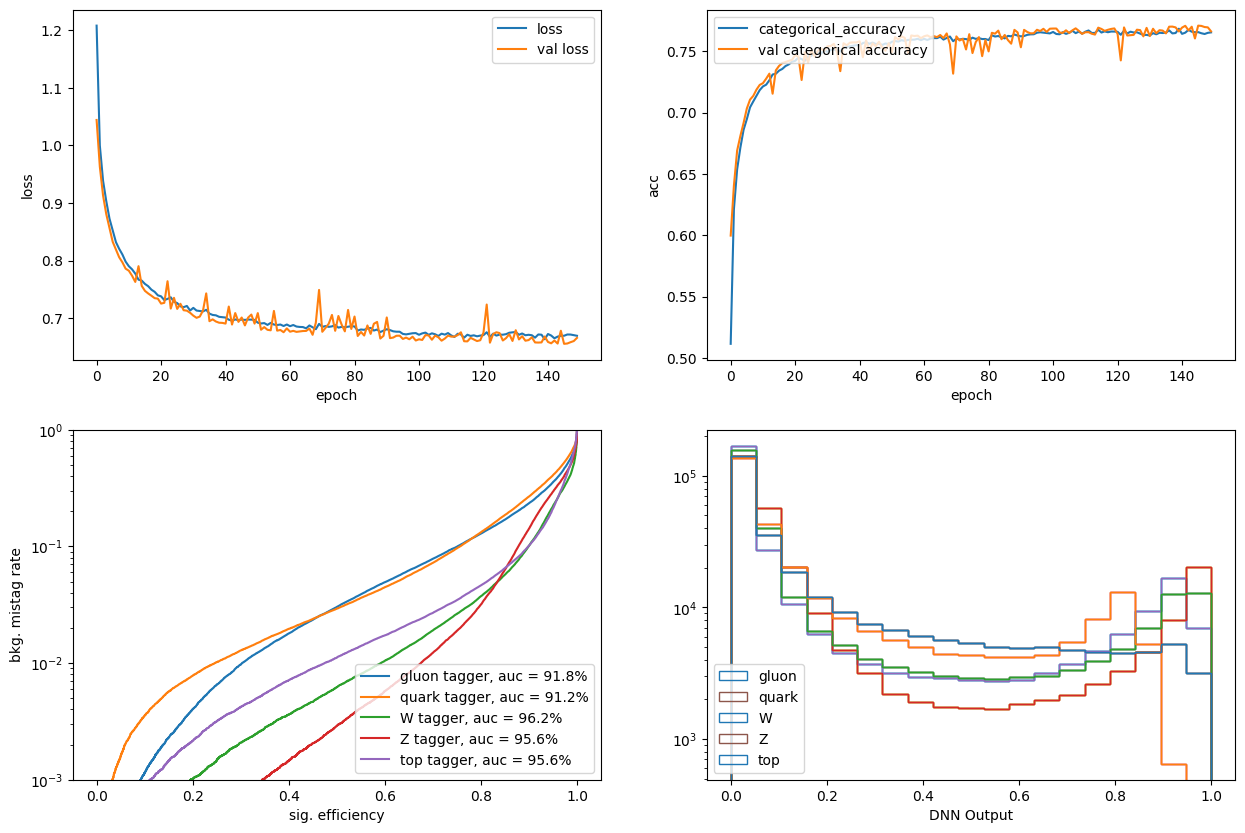

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}


ax = plt.subplot(2, 2, 3)
Y_predict = model.predict(X_test)


# Loop over classes(labels) to get metrics per class
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))

ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')


# Display plots
fig = plt.gcf()
plt.show()

In [7]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)



# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)


'''
# Save confusion matrix ndarrays to .npz file
with open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:
    vars = {}
    vars[arch]=np.array(1) # save model name
    for label in labels:
        vars['tresholds_'+label+'_'+arch] = tresholds[label]
        vars['TP_'+label+'_'+arch] = TP[label]
        vars['FP_'+label+'_'+arch] = FP[label]
        vars['TN_'+label+'_'+arch] = TN[label]
        vars['FN_'+label+'_'+arch] = FN[label]
        vars['TPR_'+arch] = tpr[label]
        vars['FPR_'+arch] = fpr[label]
        vars['NP_'+arch]= NP[label]
        vars['NN_'+arch]= NN[label]
        vars['auc_'+arch] = auc1[label] 
#        print(vars)
    np.savez(file, **vars)
'''

'''
# Save a sample of events for HLS
njets=3000
print(X_test.shape)
np.save('x_test.npy', X_test[0:njets,:])
np.save('y_test.npy', Y_test[0:njets,:])
'''

Label =  gluon  with treshold =  0.3
TPR =  0.30024117818107177
FPR =  0.009731090770338497
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000256572533055
FPR =  0.030249593639652145
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000102629013222
FPR =  0.1287547911717406
 
Label =  quark  with treshold =  0.3
TPR =  0.30003185615177685
FPR =  0.012821937955330574
 
Label =  quark  with treshold =  0.5
TPR =  0.5000353957241965
FPR =  0.029222389438040838
 
Label =  quark  with treshold =  0.8
TPR =  0.8000141582896786
FPR =  0.1321442008413996
 
Label =  W  with treshold =  0.3
TPR =  0.3001011538395597
FPR =  0.0020812416782650285
 
Label =  W  with treshold =  0.5
TPR =  0.500368611449243
FPR =  0.00621356211192168
 
Label =  W  with treshold =  0.8
TPR =  0.8000068578874278
FPR =  0.03739340638505987
 
Label =  Z  with treshold =  0.3
TPR =  0.30030683785590623
FPR =  0.0006765404222129336
 
Label =  Z  with treshold =  0.5
TPR =  0.5001285633474467
FPR =  0.0029000745487216834


"\n# Save a sample of events for HLS\nnjets=3000\nprint(X_test.shape)\nnp.save('x_test.npy', X_test[0:njets,:])\nnp.save('y_test.npy', Y_test[0:njets,:])\n"